<a href="https://colab.research.google.com/github/marcelolandivar/Python_Projects/blob/master/KMNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 
**CLASSIFYING JAPANESE’S CHARACTERS USING KMNIST** \
**COMPARISON OF TWO CONVOLUTIONAL NEURAL NETS ARCHITECTURES BASED ON DEPTH** \
By: Marcelo Landivar
Report: [Project Report](https://drive.google.com/file/d/1JNJShYI3nVrZrq-Z6PKd8xjbdCFUBgly/view?usp=sharing)

# Imports
Basic imports for the Model


In [ ]:
import numpy as np
np.random.seed(42)
import torch
import torch.optim as optim
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
from PIL import Image
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

if not torch.cuda.is_available():
    raise Exception("You should enable GPU runtime!!")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Defining the Hyper-parameters

We now define the hyperparameters that are going to be used throughout the notebook
to define the network, the data `batch_size`, the training `learning_rate`, and others.

In [ ]:
# Let's define some hyper-parameters
hparams = {
    'batch_size': 64,
    'num_epochs': 25, #Alexnet: 1 epoch to try if it worked, then 5 and then 15 to improve the results.
    #'hidden_size': 128,
    'num_classes': 10,
    'num_inputs': 784,
    'learning_rate': 1e-3, #Alexnet: initially a lr of 1e-2 for testing purposes, then change to 1e-4 for real training.
    'log_interval': 100,
    'optimizer': 'Adam', #Alexnet: Initially sdg just for testing but for the next training change to Adam directly
    'weight_decay':1e-4 # Alexnet: From the beginning weight decay but no dropout in the model
}
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Loading


The chosen dataset is the KMNIST from Torchvision dataset. The variant of this dataset is based on MNIST. The dataset is composed of 70,000 images of 28x28 in grayscale.

Extracting data/KMNIST/raw/train-images-idx3-ubyte.gz to data/KMNIST/raw


Extracting data/KMNIST/raw/train-labels-idx1-ubyte.gz to data/KMNIST/raw


Extracting data/KMNIST/raw/t10k-images-idx3-ubyte.gz to data/KMNIST/raw


Extracting data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to data/KMNIST/raw
Processing...

Done!
7


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


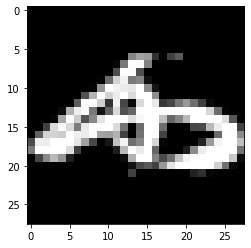

In [ ]:
data = torchvision.datasets.KMNIST(root="data", download=True)
img, lbl = data[1]
print(lbl)
fig = plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
data.class_to_idx

{'ha': 5,
 'ki': 1,
 'ma': 6,
 'na': 4,
 'o': 0,
 're': 8,
 'su': 2,
 'tsu': 3,
 'wo': 9,
 'ya': 7}

In [ ]:
transform_ = transforms.Compose([transforms.Resize((224,224), interpolation=Image.NEAREST), # resizing the image to the model input
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: torch.cat([x,x,x], 0)) # converting the image to 3 channels
                                ])


In [ ]:
root='/content/drive/My Drive/Data Science/AI_Dataset'

In [ ]:
train_dataset_ = torchvision.datasets.KMNIST(root, train=True, transform=transform_, target_transform=None, download=False)
                                     
val_dataset_ = torchvision.datasets.KMNIST(root, train=False, transform=transform_, target_transform=None, download=False)
                                    
train_dataloader_= DataLoader(train_dataset_, batch_size=hparams['batch_size'], shuffle=True, num_workers=0)
val_dataloader_ =  DataLoader(val_dataset_, batch_size=hparams['batch_size'], shuffle=False, num_workers=0)


# Models



##Alexnet

The inital model architecture selected for the task was Alexnet due to its popularity for image classification and low complexity. The Alexnet model has to be customize to be adapted to the dataset. The last FC will modified to have 10 classes.

![texto alternativo](https://www.mdpi.com/remotesensing/remotesensing-09-00848/article_deploy/html/images/remotesensing-09-00848-g001.png)

###Model Preparation

In [ ]:
# load the original Alexnet model
model = torchvision.models.alexnet(pretrained=True)  
model.children

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


<bound method Module.children of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216

In [ ]:
#Create a customize Alexnet for the KMINST dataset and check the results usign transfer learning
class Alexnet_modified(nn.Module):
    def __init__(self, num_classes):
        super(Alexnet_modified, self).__init__()
        self.features = nn.Sequential(*list(model.features.children())) #Extracting the layers of features module
        self.classifier = nn.Sequential(
            *[list(model.classifier.children())[i] for i in [1, 2, 4, 5]], #Remove the Dropouts and the final layer wihth 1000 classes
            nn.Linear(4096, num_classes), #add a Linear with the number of classes for this dataset
            nn.LogSoftmax() #Use Logsoftmax instead of Sigmoid
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

# load custom model
Custom_Alexnet = Alexnet_modified(num_classes=10).to(device)

In [ ]:
Custom_Alexnet

Alexnet_modified(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4096, out_features=4096, b

In [ ]:
#freeze the layers so we can't use the weights trained in Alexnet
#unfreeze the last layer since the training didn't have much sense with those weights
for params in Custom_Alexnet.parameters():   
  params.requires_grad=False

for i, params in enumerate(Custom_Alexnet.classifier.parameters()):
  if i>3:
    params.requires_grad=True
    print(i)

4
5


###Model Training

In [ ]:
optimizer = optim.Adam(Custom_Alexnet.parameters(), lr = hparams['learning_rate'], weight_decay=hparams['weight_decay'])
criterion = F.cross_entropy

In [ ]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_epoch(train_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss

def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += criterion(output, target, reduction='sum').item() # sum up batch loss
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

In [ ]:
training_losses = []
val_losses = []
val_accs = []


for epoch in range(1, hparams['num_epochs'] + 1):
  training_losses.append(train_epoch(train_dataloader_, Custom_Alexnet, optimizer, criterion, hparams))
  val_loss, val_acc = test_epoch(val_dataloader_, Custom_Alexnet, hparams)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

#Initial training for testing for Alexnet a Acc of 62%, the second attempt increased to 75%, third to 79% and last 83%
#Each of the times the model was instantiated again.
#For more information, please refer to the report

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.334892
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.994418
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.469670
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.541400
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.603581
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.474479
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.457884
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.640936
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.481149
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.549420

Val set: Average loss: 0.8502, Accuracy: 7352/10000 (74%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.520102
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.416010
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.483778
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.454384
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.353405
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.442672
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.250223
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.440009
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.671034
Tr

###Visualization of Results

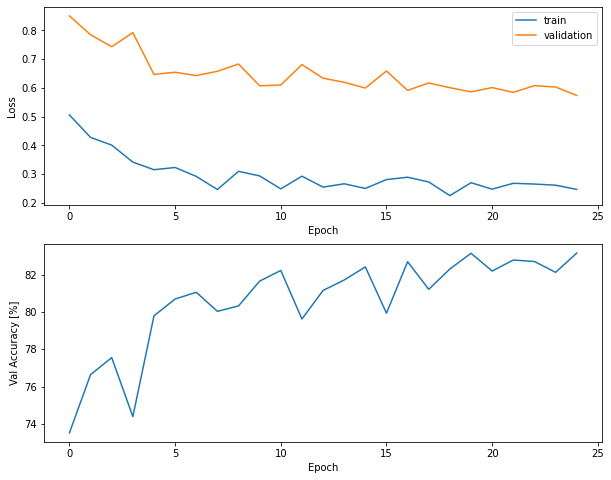

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(training_losses, label='train')
plt.plot(val_losses, label='validation')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy [%]')
plt.plot(val_accs)

#Validation was still decreasing so it was possible to increase the epochs to improve the accuracy

##RESNET 101

The results of Alexnet could clearly be improved by larger training. However, my intention is to add more complexity to the seleciton a try Resnet 101 and compare traning with the same amount of epochs and later fine tune the model to increase accuracy in the classification. Since the dataset preparation for RESNET101 was different and the 1 channel grayscale images is kept, then the model has to customize so that the input is one channel. Some of the dimensions also were customized just a test.

![texto alternativo](https://www.researchgate.net/profile/Panqu_Wang/publication/314115448/figure/fig6/AS:668592458715147@1536416272927/Architecture-of-ResNet-101-network-with-Dense-Upsampling-Convolution-DUC-layer.ppm)

###Model Preparation

In [ ]:
import math 

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

"""
    Based on the Documentation of Pytorch - Resnet model and modified for taking the KMNIST
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride) #Downsample the image when stride is more than 1
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample #to downsample the input 
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False) #Dimensionality reduction and feature reduction for kernel 1x1 (like Inception)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)

        return x

In [ ]:
def resnet101(pretrained=False, **kwargs):

  """Building a resnet101 based on Pytorch documentation
    It consits of 4 layers or sectionts of Bottlenecks of 
     layer0 - 3 Bottlenecks
     layer0 - 4 Bottlenecks
     layer0 - 23 Bottlenecks
     layer0 - 3 Bottlenecks    """

  model = ResNet(Bottleneck, [3,4,23,3], **kwargs)
  return model

my_resnet = resnet101(pretrained=True, num_classes=hparams['num_classes']).to(device)

###Model Training

In [ ]:
optimizer = optim.Adam(my_resnet.parameters(), lr = hparams['learning_rate'], weight_decay=hparams['weight_decay'])
criterion = F.cross_entropy

In [ ]:
training_losses = []
val_losses = []
val_accs = []


for epoch in range(1, hparams['num_epochs'] + 1):
  training_losses.append(train_epoch(train_dataloader_alexnet, my_resnet, optimizer, criterion, hparams))
  val_loss, val_acc = test_epoch(val_dataloader_alexnet, my_resnet, hparams)
  val_losses.append(val_loss)
  val_accs.append(val_acc)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.534369
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.836539
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.478942
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.442379
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.360744
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.462401
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.268417
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.356363
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.127314
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.175784

Val set: Average loss: 0.9947, Accuracy: 7095/10000 (71%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.250200
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.155133
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.254603
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.183180
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.529389
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.054894
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.172983
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.187997
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.198119
Tr

In [ ]:
#84% Acc, 0.5459 loss, epochs 3 and 0.001 lr
#95% Acc, 0.1862 loss, epochs 15 and 0.0001 lr
#96% Acc, 0.1476 loss, epochs 25 and 0.001 lr

### Visualization of Results

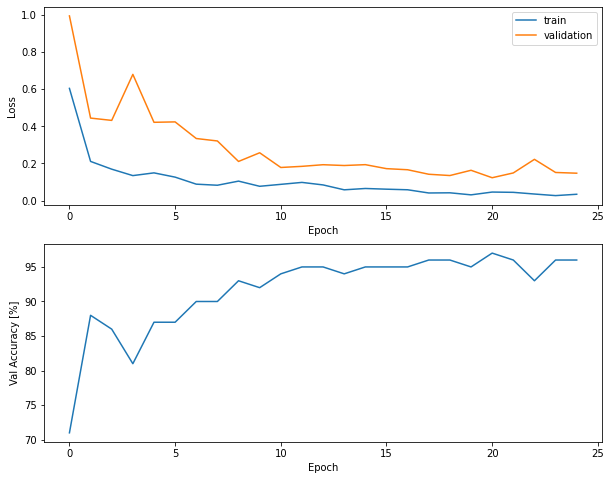

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(training_losses, label='train')
plt.plot(val_losses, label='validation')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy [%]')
plt.plot(val_accs)
